In [1]:
%pylab inline
import scipy.stats as stats
import astropy.stats as astats
import numpy.random as random

Populating the interactive namespace from numpy and matplotlib


# Results when averaging data together

In [2]:
nsims = int(1E5)
navg = 100
data = random.randn(nsims, navg)

# average each set of navg values
means = np.mean(data, axis=1)

- Using the below code block, __plot a histogram of the distribution of the means from each simulation, with binsize 0.01, over the range from -2 to +2 (what should you set the `bins` and `range` keywords to be for that?)__

- __Determine the standard deviation of the array of means.__

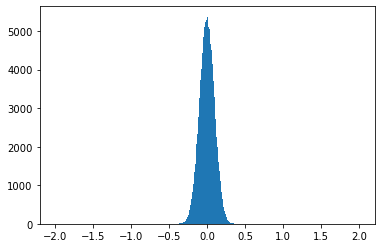

Standard deviation: 0.09954


In [3]:
plt.hist(means, bins=3*navg, range=(-2, 2))
plt.show()
std = np.std(means)
print(f"Standard deviation: {round(std, 5)}")

- Now, in the same code box, also __create a second set of simulations with `navg` = 9.  Plot the histogram of results from these simulations on top of the histogram for averaging 100 measurements, and calculate the standard deviation of the new array of means.__



- __Discuss with your group: How do you explain the differences between the results (both qualitatively and quantitatively)? How does the scatter of the means scale with `navg`?__

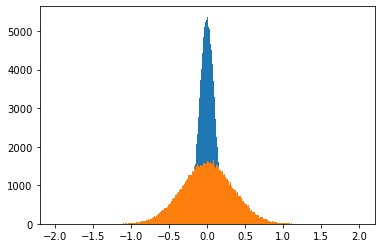

Standard deviation: 0.09954
New standard deviation: 0.33308


In [4]:
navg9 = 9
data9 = random.randn(nsims, navg9)

# average each set of navg values
means9 = np.mean(data9, axis=1)

plt.hist(means, bins=3*navg, range=(-2, 2))
plt.hist(means9, bins=3*navg, range=(-2, 2))
plt.show()
print(f"Standard deviation: {round(std, 5)}")
std9 = np.std(means9)
print(f"New standard deviation: {round(std9, 5)}")

# Determining the Asymptotic Relative Efficiency of the median

__Run the code in the below box repeatedly; what is the ratio of standard deviations of the medians vs. the means?__  

__Discuss with your group: What does this imply about the sample size needed for the standard deviation of the median to match the standard deviation of the mean?__

In [5]:
nsims = int(1E4)
navg = int(5E3)
data = random.randn(nsims, navg)
means = np.mean(data, axis=1)
medians = np.median(data, axis=1)

print(f'std. dev. of the means: {np.std(means, ddof=1):.4f}')
print(f'std. dev. of the medians: {np.std(medians, ddof=1):.4f}')

print(f'ratio of std. devs.: {np.std(medians, ddof=1) / np.std(means, ddof=1):.4f}')

std. dev. of the means: 0.0141
std. dev. of the medians: 0.0175
ratio of std. devs.: 1.2413


# Examples of applying robust statistics

For convenience, let's define two functions: `hlmean` and `mode2`.

In [6]:
def hlmean(data,nsamp=-1):
    # PURPOSE:
    #
    #  Calculate Hodges-Lehmann estimator of mean, using nsamp
    #   bootstraps from the data
    #
    # The Hodges-Lehmann estimator is, formally, the median value of
    #  (x_i+x_j)/2 over all pairs of indices i,j .
    # Here, we estimate that quantity using nsamp randomly chosen values
    # of i & j, rather than using all possible values.
    #
    # Although it has much of the robustness of an ordinary median, the
    # H-L estimator yields much smaller errors (equivalent to the mean of
    # >96% as much data, while the median has errors equivalent to the
    # standard error of 64% as much data).
    #
    # CALLING SEQUENCE:
    #
    #  result=hlmean(data [,nsamp=nsamp])
    #
    # INPUTS:
    #
    #  data: array of values to calculate the H-L mean of
    #
    # OPTIONAL KEYWORD PARAMETERS:
    #
    #  nsamp= : if set, hlmean will use this number of bootstrap
    #  samples to do the calculation.  If not set, it will use a number of random pairs equal to
    #  50 times the number of elements of the data array
    #
    # OUTPUTS:
    #
    #  result: sampling-derived estimate of the H-L mean estimator
    #
    # EXAMPLE:
    #    test=[1,2,0,1,2,20.]
    #    print hlmean(test)
    
    ndata=len(data)
    
    # if the number of samples has not been provided, set it to 50*the size of the data array
    
    if nsamp < 0:
        nsamp=50.*ndata
    nsamp=int(nsamp)

# create resampled version of original data
    newdata = np.random.choice(data,size=(nsamp,2))
    
    # average x1 + x2 from each random draw
    mn = (newdata[:,0]+newdata[:,1])/2.
    
    # calculate the median of the averages
    return(np.median(mn))


In [7]:
def mode2(data,**kwargs):
# note: provide bins and (optionally) range keywords to not use
# defaults of np.histogram (10 bins, full range)
    counts,edges=np.histogram(data,**kwargs)
    whmax=np.argmax(counts)
    mode=(edges[whmax]+edges[whmax+1])/2
    return(mode)

## Trying different statistics for location

Now, let's generate $10^5$ values from a standard normal distribution, and compare various statistics for the location of the sample.  __What value do you expect here?  Which statistics come closest? Compare results with your neighbors!__

In [8]:
ndata = int(1E5)
data = random.randn(ndata)

In [9]:
print(f'Mean: {data.mean():.4f}')
print(f'Median: {np.median(data):.4f}')
print(f'Mode: {mode2(data,bins=np.linspace(-10,10,2001)):.4f}')
print(f'H-L mean: {hlmean(data):.4f}')
print()

limits=np.percentile(data,(10,90))
print(f'10% Trimmed mean: {stats.tmean(data,limits=limits):.4f}')

clipped_data,low_threshold,high_threshold =  \
    stats.sigmaclip(data,low=3.,high=3.)

print(f'Sigma-clipped: {np.mean(clipped_data):.4f}')

print()
winsor_data = stats.mstats.winsorize(data,limits=(.1,.1))
print(f'Winsorized: {np.mean(winsor_data):.4f}')
print(f'Biweight: {astats.biweight_location(data):.4f}')

Mean: 0.0055
Median: 0.0053
Mode: 0.0350
H-L mean: 0.0048

10% Trimmed mean: 0.0050
Sigma-clipped: 0.0049

Winsorized: 0.0054
Biweight: 0.0050


# Doing a more complicated Monte Carlo

Consider a mixture of two Gaussians: a fraction  $(1-f_{outlier})$  of objects are distributed as $N(3150,930^2)$, and a fraction $f_{outlier}$ are distributed as $N(4750,200^2)$.  We can implement this by randomly selecting objects as outliers with probability $f_{outlier}$, and assigning random values according to whether they are an outlier or not.

In [10]:
nsims=int(5E4)
ndata=100
foutlier=0.1

isoutlier=random.rand(nsims,ndata) < foutlier

fakedata=(1-isoutlier)*(random.randn(nsims,ndata)*930.+3150) \
+ (isoutlier)*(random.randn(nsims,ndata)*200.+4750)

__In the code box below, plot a histogram of the full set of fake data; and then choose one single simulation and plot the histogram for it. Use a bin size of 100 km/s.__  

__Note__: To plot histograms of a multi-dimensional array, use `np.ravel(arrayname)`, not just `arrayname`, in the call to `plt.hist`.  That routine causes Python to treat the array as one-dimensional.  

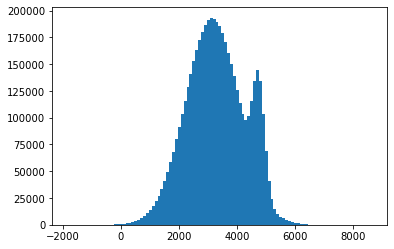

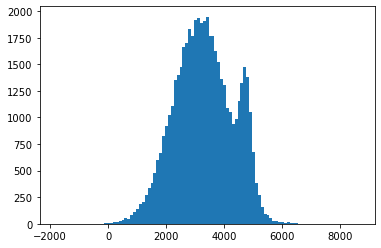

In [11]:
binsize = np.arange(fakedata.min(), fakedata.max(), 100)
plt.hist(np.ravel(fakedata), bins=binsize)
plt.show()

binsize = np.arange(fakedata.min(), fakedata.max(), 100)
plt.hist(np.ravel(fakedata[:,5]), bins=binsize)
plt.show()

# Interpreting error estimates

Frequentist statistics focuses on what will be observed, given an assumed truth.  Let's consider two possible interpretations:

- 68.3% of the time we do an experiment like this, the true mean will lie between $m-\hat{\sigma_\bar{x}}$ and $m+\hat{\sigma_\bar{x}}$, where $m$ is the observed mean and $\hat{\sigma_\bar{x}}$ is the sample standard deviation of the mean determined from the data, as $\sigma_x \over \sqrt{n}$; or
- 68.3% of the time we do an experiment like this, the true mean will lie between $m-{\sigma_\bar{x}}$ and $m+{\sigma_\bar{x}}$, where $\sigma_\bar{x}$ is the standard error we would calculate with perfect knowledge of the distribution, as $\sigma \over \sqrt{n}$.

Let's test this out with simulations of measuring the mean of 10 or 100 measurements drawn from $N(0,1)$.

In [12]:
# simulating averaging 10 measurements, 100_000 times
nsims=int(1E5)
ndata=10
data=random.randn(nsims, ndata) 

means = np.mean(data, axis=1)  # mean of each set of 10 measurements
sample_std = np.std(data, axis=1, ddof=1)    # standard deviation of each set of 10 measurements. 
# Note that the axis= keyword works with np.std! Do ?np.std for details.

# sample standard errors determined from each random dataset
sample_serr = sample_std / np.sqrt(ndata) 

# standard error calculated knowing the actual distribution
actual_serr = 1 / np.sqrt(ndata)        

__Using the below code box, plot the histograms of `means` and `sample_std` (as separate figures).  Are they both Normally distributed (Gaussian)?__


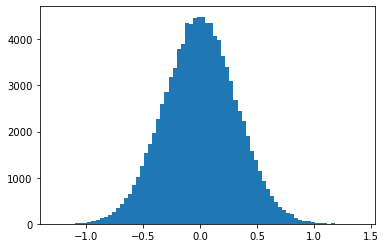

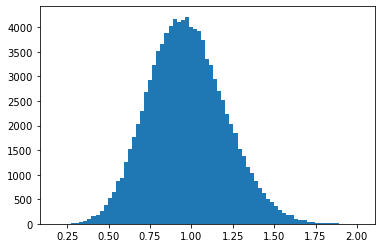

In [13]:
plt.hist(means, bins=75) # follows a Gaussian distribution
plt.show()
plt.hist(sample_std, bins=75) # does NOT follow a Gaussian distribution. distribution isn't symmetric
plt.show()

__In the below code box, write code to determine:__


- What fraction of the time when we do an experiment like this does the true mean lie between `means-sample_serr` and `means+sample_serr`?

- What fraction of the times when we do an experiment like this does the true mean lie between `means-actual_serr` and `means+actual_serr`?

Recall: 68.3% of the time a normally-distributed value will be within 1 sigma of the mean.  __Which matches this?__

In [14]:
in_sample = np.logical_and((means - sample_serr) < 0, (means + sample_serr) > 0).sum() / len(means)
in_actual = np.logical_and((means - actual_serr) < 0, (means + actual_serr) > 0).sum() / len(means)
print(f"Sample: {round(in_sample, 5)}")
print(f"Actual: {round(in_actual, 5)}") # 68.3 confidence interval closer when we use actual standard error

Sample: 0.65552
Actual: 0.6814


In [15]:
# simulating averaging 10 measurements, 100_000 times
nsims=int(1E5)
ndata=100
data=random.randn(nsims, ndata)

means = np.mean(data, axis=1)  # mean of each set of 10 measurements
sample_std = np.std(data, axis=1, ddof=1)    # standard deviation of each set of 10 measurements. 
# Note that the axis= keyword works with np.std! Do ?np.std for details.

# sample standard errors determined from each random dataset
sample_serr = sample_std / np.sqrt(ndata) 

# standard error calculated knowing the actual distribution
actual_serr = 1 / np.sqrt(ndata)  

in_sample = np.logical_and((means - sample_serr) < 0, (means + sample_serr) > 0).sum() / len(means)
in_actual = np.logical_and((means - actual_serr) < 0, (means + actual_serr) > 0).sum() / len(means)
print(f"Sample: {round(in_sample, 5)}")
print(f"Actual: {round(in_actual, 5)}") # 68.3 confidence interval closer when we use actual standard error

Sample: 0.67993
Actual: 0.68292


# Calculating proper confidence intervals

We can use the `cdf` method of an object from the `stats.t` class to calculate how much probability we expect to lie between `means-sample_serr` and `means+sample_serr`, for the two scenarios we looked at (10 data points = 9 degrees of freedom, 100 = 99 DOF).  __Compare to the results from your Monte Carlo simulations.__

In [16]:
print(stats.t.cdf(1.,9)-stats.t.cdf(-1.,9))
print(stats.t.cdf(1.,99)-stats.t.cdf(-1.,99))

0.6565636038620863
0.6802515258606983


We can use the `ppf` method of an object from the `stats.t` class to calculate the $t$ value such that the CDF is 0.8413 (i.e., the upper edge of a 68.3% confidence interval).  Because the t distribution is symmetric, the lower edge will just be opposite  in sign but have the same absolute value.  __Let's calculate these cutoffs and test that the resulting intervals in fact contain 68.3% of the probability:__

In [17]:
cutoff9 = stats.t.ppf(0.8413,9)
cutoff99 = stats.t.ppf(0.8413,99)

print(f'9  DOF: Cutoff value: {cutoff9:.4f}')
print(f'        Probability contained: {stats.t.cdf(cutoff9,9)-stats.t.cdf(-cutoff9,9):.4f}')
print(f'99 DOF: Cutoff value: {cutoff99:.4f}')
print(f'        Probability contained: {stats.t.cdf(cutoff99,99)-stats.t.cdf(-cutoff99,99):.4f}')

9  DOF: Cutoff value: 1.0585
        Probability contained: 0.6826
99 DOF: Cutoff value: 1.0049
        Probability contained: 0.6826


How much difference does the difference between a $t$ distribution and a Gaussian make, as a function of the amount of data we have and which confidence interval we are looking at?  __Evaluate how close the cutoffs are to those for a Gaussian distribution, as a function of the number of degrees of freedom, for 68%, 95%, and 99% confidence intervals.__

In [18]:
print('68% range limits:')

for i in np.arange(2,20,2): 
    print(f'DOF: {i:2d}   {stats.t.ppf(0.1587,i-1):.5f}, {stats.t.ppf(0.8413,i-1):5f}')
    
print('\n95% range:')

for i in np.arange(2,20,2): 
    print(f'DOF: {i:2d}   {stats.t.ppf(0.025,i-1):.5f}, {stats.t.ppf(0.975,i-1):5f}')
    
    
print('\n99% range:')
    
for i in np.arange(2,20,2): 
    print(f'DOF: {i:2d}   {stats.t.ppf(0.005,i-1):.5f}, {stats.t.ppf(0.995,i-1):5f}')
          
print('\n large N limits (=cutoffs for a Gaussian distribution):' )
print(f'68%: {stats.t.ppf(1-0.1587,1E4):.5f}')
print(f'95%: {stats.t.ppf(1-0.025,1E4):.5f}')
print(f'99%: {stats.t.ppf(1-0.005,1E4):.5f}')

68% range limits:
DOF:  2   -1.83672, 1.836722
DOF:  4   -1.19662, 1.196616
DOF:  6   -1.11028, 1.110278
DOF:  8   -1.07650, 1.076499
DOF: 10   -1.05852, 1.058520
DOF: 12   -1.04736, 1.047365
DOF: 14   -1.03977, 1.039769
DOF: 16   -1.03427, 1.034265
DOF: 18   -1.03009, 1.030093

95% range:
DOF:  2   -12.70620, 12.706205
DOF:  4   -3.18245, 3.182446
DOF:  6   -2.57058, 2.570582
DOF:  8   -2.36462, 2.364624
DOF: 10   -2.26216, 2.262157
DOF: 12   -2.20099, 2.200985
DOF: 14   -2.16037, 2.160369
DOF: 16   -2.13145, 2.131450
DOF: 18   -2.10982, 2.109816

99% range:
DOF:  2   -63.65674, 63.656741
DOF:  4   -5.84091, 5.840909
DOF:  6   -4.03214, 4.032143
DOF:  8   -3.49948, 3.499483
DOF: 10   -3.24984, 3.249836
DOF: 12   -3.10581, 3.105807
DOF: 14   -3.01228, 3.012276
DOF: 16   -2.94671, 2.946713
DOF: 18   -2.89823, 2.898231

 large N limits (=cutoffs for a Gaussian distribution):
68%: 0.99987
95%: 1.96020
99%: 2.57632


# If you have extra time

- Explore the effect that the number of samples has on the accuracy of `hlmean`.  If you use ndata, 10$\times$ndata, 25$\times$ndata, or 100$\times$ndata samples, how much does the estimate coming from `hlmean` vary when you rerun it?  You can use e.g. 100 or 1000 values from N(0,1) in testing.

- Apply each of the estimators of location (applied above) on a situation where 10% of values are drawn from N(2,1) instead of N(0,1) (using an foutlier parameter as in the clusters example).  Which estimators appear to be most robust?

